# Capstone Project - The Battle of the Neighborhoods

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

# Introduction/Business Problem
## 1. A description of the problem and a discussion of the background

In this project I will compare neiberhoods of two big cities in Europe, Amsterdam and Berlin.

My target audience are people that know one city pretty well and are wondering which neighborhood of the other city is most similar to the one they like.

They could use this data to choose location of their hotel or apartment when visiting or moving to the other city. 

Criteria that I will take into the consideration are, Population density and venues nearby

# Data 
## 2. A description of the data and how it will be used to solve the problem. 

The data that I have collected:
* postal code
* median age
* neighborhood names
* area
* population
* geo location

I have dropped **median age** later because it is different in both cities and seems to not change among neighborhoods in the city, this factor is country specific  


Some details on scraping the data:

Postal codes, neigboorhood info and geo location I have got from, **https://postal-codes.cybo.com/germany/berlin/#listcodes**, **https://postal-codes.cybo.com/netherlands/amsterdam/#listcodes** 

The details page on **cybo.com** have **Neighborhoods**, **Coordinates**, **area** and **population** fields 

First entry from the Berlin codes:


Postal Code|City|Administrative Region|Population|Area
 --- | --- | --- | --- | --- 
10115|Berlin|Berlin|16,678|2.421 km²

And in the details page **https://postal-codes.cybo.com/germany/10115_berlin-berlin/** fields that I have used:

| | |
:--- | --- 
**Neighborhoods**|Mitte
**Coordinates**|52.533706954560394° / 13.387223860255002°
**Median Age**|43 years

I have used Foursquare API to get the information about the venues **https://api.foursquare.com/v2/venues/explore**


# Methodology

In the project I will use the postal codes areas of both cities and I will get nearby venues in the radius based on area size. The density field is calculated for each postal code to represent the area and population relationship. The KMeans algorithm is going to be used. I will calculate the score for various k values to get optimal k value. Because the clustering algorithm is unsupervised I will use map and top 10 venues for each cluster to determine properties of each cluster.

# Analysis

Scraping the cybo website is in the separate notebook. The process is explained there. Separate notebook was used to scrape the data, save it to the disk and never repeat the process because webscraping is slow and can be blocked by site protection.

In [1]:
import pandas as pd
import numpy as np
import folium
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from IPython.core.display import display, HTML
from sklearn.cluster import KMeans
from sklearn import preprocessing
import matplotlib.cm as cm
import matplotlib.colors as colors

I used this function to clean the webscraped data, some rows have NaN fields so I drop them. I have also calculated population density and added it as a column.

In [2]:
def clean_df_codes(df: pd.DataFrame):
    df = df.replace(',','', regex=True)
    df['Population'] = pd.to_numeric(df['Population'], errors='coerce')
    df['Area km²'] = pd.to_numeric(df['Area km²'], errors='coerce')
    df.dropna(inplace=True)
    df['Population density per km²'] = df['Population']/df['Area km²']
    df['Population density per km²'] = df['Population density per km²'].round(2)
    df['Population'] = df['Population'].astype(int)
    return df

I import the data from the disk to the dataframe

In [3]:
berlin_codes_df = pd.read_csv('berlin_codes.csv', delimiter=';')
berlin_codes_df = clean_df_codes(berlin_codes_df)
berlin_codes_df.head()

,Postal Code,City,Administrative Region,Population,Area km²,Population density per km²
0,10115,Berlin,Berlin,16678,2.421,6888.89
1,10117,Berlin,Berlin,24223,3.321,7293.89
2,10119,Berlin,Berlin,7408,0.857,8644.11
3,10178,Berlin,Berlin,14069,1.872,7515.49
4,10179,Berlin,Berlin,15897,2.183,7282.18


In [4]:
berlin_details_df = pd.read_csv('berlin_details.csv', delimiter=';', thousands=',')
berlin_details_df.head()

,Postal Code,Median Age,Neighborhoods,Latitude,Longitude
0,10115,43.0,Mitte,52.533707,13.387224
1,10117,43.0,Mitte,52.518746,13.390193
2,10119,43.0,"Bezirk Pankow, Mitte",52.532666,13.407149
3,10178,43.0,Mitte,52.523474,13.412203
4,10179,43.0,"Luisenstadt, Mitte",52.514591,13.419699


In [5]:
amsterdam_codes_df = pd.read_csv('amsterdam_codes.csv', delimiter=';')
amsterdam_codes_df = clean_df_codes(amsterdam_codes_df)
amsterdam_codes_df.rename(columns={'Postal District': 'Postal Code'}, inplace=True)
amsterdam_codes_df.head()

,Postal Code,City,Administrative Region,Population,Area km²,Population density per km²
0,1011,Amsterdam,North Holland,6606,1.032,6401.16
1,1012,Amsterdam,North Holland,7067,1.207,5855.01
2,1013,Amsterdam,North Holland,26792,6.300,4252.70
3,1014,Amsterdam,North Holland,15056,2.699,5578.36
4,1015,Amsterdam,North Holland,5926,0.776,7636.60


In [6]:
amsterdam_details_df = pd.read_csv('amsterdam_details.csv', delimiter=';', thousands=',')
amsterdam_details_df.head()

,Postal Code,Median Age,Neighborhoods,Latitude,Longitude
0,1011,36.3,"Amsterdam-Centrum, Stadsdeel Centrum",52.371124,4.903752
1,1012,36.3,"Amsterdam-Centrum, Centrum, De Wallen, Stadsde...",52.373179,4.894910
2,1013,36.3,"Amsterdam-Centrum, Amsterdam-West, Haarlemmerb...",52.387662,4.883396
3,1014,36.3,"Amsterdam-West, Bedrijventerrein Sloterdijk, S...",52.393066,4.853503
4,1015,36.3,"Amsterdam-Centrum, Grachtengordel-West, Jordaan",52.378205,4.882973


I'm joining two dataframes, one with details and one with basic information, this is only because of how the data was stored on the webstie that I have used. I prefer to do that using pandas after I have downloaded all the data.

In [7]:
berlin_merged = pd.merge(berlin_codes_df, berlin_details_df, on='Postal Code', how='left')
berlin_merged.to_csv('berlin_regions.csv', sep=';')
berlin_merged.head()

,Postal Code,City,Administrative Region,Population,Area km²,Population density per km²,Median Age,Neighborhoods,Latitude,Longitude
0,10115,Berlin,Berlin,16678,2.421,6888.89,43.0,Mitte,52.533707,13.387224
1,10117,Berlin,Berlin,24223,3.321,7293.89,43.0,Mitte,52.518746,13.390193
2,10119,Berlin,Berlin,7408,0.857,8644.11,43.0,"Bezirk Pankow, Mitte",52.532666,13.407149
3,10178,Berlin,Berlin,14069,1.872,7515.49,43.0,Mitte,52.523474,13.412203
4,10179,Berlin,Berlin,15897,2.183,7282.18,43.0,"Luisenstadt, Mitte",52.514591,13.419699


In [8]:
amsterdam_merged = pd.merge(amsterdam_codes_df, amsterdam_details_df, on='Postal Code', how='left')
amsterdam_merged.to_csv('amsterdam_regions.csv', sep=';')
amsterdam_merged.head()

,Postal Code,City,Administrative Region,Population,Area km²,Population density per km²,Median Age,Neighborhoods,Latitude,Longitude
0,1011,Amsterdam,North Holland,6606,1.032,6401.16,36.3,"Amsterdam-Centrum, Stadsdeel Centrum",52.371124,4.903752
1,1012,Amsterdam,North Holland,7067,1.207,5855.01,36.3,"Amsterdam-Centrum, Centrum, De Wallen, Stadsde...",52.373179,4.894910
2,1013,Amsterdam,North Holland,26792,6.300,4252.70,36.3,"Amsterdam-Centrum, Amsterdam-West, Haarlemmerb...",52.387662,4.883396
3,1014,Amsterdam,North Holland,15056,2.699,5578.36,36.3,"Amsterdam-West, Bedrijventerrein Sloterdijk, S...",52.393066,4.853503
4,1015,Amsterdam,North Holland,5926,0.776,7636.60,36.3,"Amsterdam-Centrum, Grachtengordel-West, Jordaan",52.378205,4.882973


I check basic descriptive statistic on the data I have, I see that median age is pretty much the same among one city, I have discarded this field from the analysis. I see that population density is pretty diverse but still similar among both cities this indicates that the division by postal code areas is good way to compare cities.

In [9]:
berlin_merged.describe()

,Postal Code,Population,Area km²,Population density per km²,Median Age,Latitude,Longitude
count,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000
mean,12262.685567,17621.417526,5.484062,5355.793144,43.095876,52.505112,13.393498
std,1287.341587,10837.421963,8.476452,2050.216635,0.559777,0.055279,0.116044
min,10115.000000,2869.000000,0.444000,277.140000,43.000000,52.363244,13.143126
25%,10823.500000,9730.250000,1.619250,4190.742500,43.000000,52.467486,13.317487
50%,12356.000000,15129.000000,2.952000,5876.970000,43.000000,52.504849,13.384287
75%,13354.500000,22677.500000,6.500000,6699.890000,43.000000,52.542604,13.460486
max,15562.000000,57275.000000,77.500000,8950.650000,48.000000,52.642215,13.799300


In [10]:
amsterdam_merged.describe()

,Postal Code,Population,Area km²,Population density per km²,Median Age,Latitude,Longitude
count,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000
mean,1060.358025,9830.283951,2.646741,5044.703704,36.403704,52.364022,4.892978
std,29.733949,5809.643077,2.612032,1851.930209,0.667354,0.029773,0.057825
min,1011.000000,878.000000,0.242000,175.110000,36.300000,52.293492,4.758401
25%,1034.000000,6128.000000,1.128000,4252.700000,36.300000,52.347895,4.853503
50%,1061.000000,8852.000000,1.880000,5398.920000,36.300000,52.362742,4.894881
75%,1083.000000,13174.000000,2.915000,6486.340000,36.300000,52.387662,4.935605
max,1114.000000,28120.000000,13.900000,7636.600000,42.300000,52.419563,5.016719


I get geographic location of both cities to show them on the map

In [11]:
address_berlin = 'Berlin, Germany'
address_amsterdam = 'Amsterdam, Netherlands'

geolocator = Nominatim(user_agent="explorer")
berlin_location = geolocator.geocode(address_berlin)
berlin_lat, berlin_lon = (berlin_location.latitude, berlin_location.longitude)

amsterdam_location = geolocator.geocode(address_amsterdam)
amsterdam_lat, amsterdam_lon = (amsterdam_location.latitude, amsterdam_location.longitude)
print(f'The geograpical coordinate of Berlin are {berlin_lat}, {berlin_lon}. and Amsterdam are {amsterdam_lat}, {amsterdam_lon}')

The geograpical coordinate of Berlin are 52.5170365, 13.3888599. and Amsterdam are 52.3727598, 4.8936041


In [12]:
def get_map(df: pd.DataFrame, city_lat, city_lon, zoom=10):
    '''function creates map for the specific location and points of interest'''
    map = folium.Map(location=[city_lat, city_lon], zoom_start=zoom)

    # add markers to map
    for lat, lng, admin_region, neighborhoods in zip(df['Latitude'], df['Longitude'], df['Administrative Region'], df['Neighborhoods']):
        label = f'{neighborhoods}, {admin_region}'
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map)  
        
    return map

In [13]:
def show_maps_sidebyside(map1, map2):
    htmlmap = HTML('<iframe srcdoc="{}" style="float:left; width: {}px; height: {}px; display:inline-block; width: 49.7%; margin: 0 auto; border: 2px solid black"></iframe>'
            '<iframe srcdoc="{}" style="float:right; width: {}px; height: {}px; display:inline-block; width: 49.7%; margin: 0 auto; border: 2px solid black"></iframe>'
            .format(map1.get_root().render().replace('"', '&quot;'),500,500,
                    map2.get_root().render().replace('"', '&quot;'),500,500))
    display(htmlmap)
 

In [14]:
berlin_map = get_map(berlin_merged, berlin_lat, berlin_lon, 10)
amsterdam_map = get_map(amsterdam_merged, amsterdam_lat, amsterdam_lon, 11)

Maps shows the location of the neighborhoods in both cities

In [15]:
%%capture --no-display
show_maps_sidebyside(berlin_map, amsterdam_map)

I have collected the venues info from four square in separate notebook to save the data to the disk and not repeat the process. This is due to limits on the API calls and avoid possible API unavailability 

In [16]:
berlin_venues = pd.read_csv('berlin_venues.csv', sep=';')
berlin_onehot = pd.get_dummies(berlin_venues[['Venue Category']], prefix="", prefix_sep="")
berlin_onehot['Postal Code'] = berlin_venues['Neighborhood'] 

I change the venues info to one-hot encoded columns then I have grupped by postal code using mean function, this way we get the frequency of appearance of the venues in each location

In [17]:
cols = list(berlin_onehot)
cols.insert(0, cols.pop(cols.index('Postal Code')))
berlin_onehot = berlin_onehot.loc[:, cols]
berlin_grouped = berlin_onehot.groupby('Postal Code').mean().reset_index()
berlin_grouped.head()

,Postal Code,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Service,Airport Terminal,American Restaurant,Amphitheater,...,Waterfront,Whisky Bar,Windmill,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,10115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.00,0.0,0.0
1,10117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.030000,0.00,0.0,0.0,0.01,0.0,0.0
2,10119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.021978,0.00,0.0,0.0,0.00,0.0,0.0
3,10178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.01,0.0,0.0,0.00,0.0,0.0
4,10179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.00,0.0,0.0


In [18]:
amsterdam_venues = pd.read_csv('amsterdam_venues.csv', sep=';')
amsterdam_onehot = pd.get_dummies(amsterdam_venues[['Venue Category']], prefix="", prefix_sep="")
amsterdam_onehot['Postal Code'] = amsterdam_venues['Neighborhood'] 

In [19]:
cols = list(amsterdam_onehot)
cols.insert(0, cols.pop(cols.index('Postal Code')))
amsterdam_onehot = amsterdam_onehot.loc[:, cols]
amsterdam_grouped = amsterdam_onehot.groupby('Postal Code').mean().reset_index()
amsterdam_grouped.head()

,Postal Code,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,...,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Windmill,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,1011,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.025,0.00,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,1012,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.02,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,1013,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.00,...,0.0,0.0,0.0,0.0,0.010000,0.000000,0.000000,0.020000,0.0,0.0
3,1014,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.00,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4,1015,0.0,0.0,0.0,0.010989,0.0,0.0,0.0,0.000,0.00,...,0.0,0.0,0.0,0.0,0.010989,0.010989,0.010989,0.010989,0.0,0.0


Then I join the dataframes with density info of Berlin and Amsterdam into one to prepare the data for clustering

In [20]:
berlin_conds = berlin_merged[['Postal Code', 'Population density per km²', 'Median Age']]
amsterdam_conds = amsterdam_merged[['Postal Code', 'Population density per km²', 'Median Age']]

both_cities_conds = pd.concat([berlin_conds, amsterdam_conds])
print("Berlin df: ", berlin_conds.shape, "Amsterdam df: ", amsterdam_conds.shape, "both cities df: ", both_cities_conds.shape)

Berlin df:  (194, 3) Amsterdam df:  (81, 3) both cities df:  (275, 3)


I normalize density data, Median Age is dropped later 

In [21]:
both_cities_conds_id = both_cities_conds.set_index('Postal Code')
min_max_scaler = preprocessing.MinMaxScaler()
both_cities_conds = pd.DataFrame(min_max_scaler.fit_transform(both_cities_conds_id), columns=both_cities_conds_id.columns, index=both_cities_conds_id.index)
both_cities_conds = both_cities_conds.reset_index()
both_cities_conds.head()

,Postal Code,Population density per km²,Median Age
0,10115,0.765056,0.57265
1,10117,0.811207,0.57265
2,10119,0.965069,0.57265
3,10178,0.836459,0.57265
4,10179,0.809873,0.57265


Here I combine onehot data into one data frame

In [22]:
both_cities_grouped = pd.concat([amsterdam_grouped, berlin_grouped])
both_cities_grouped.fillna(0, inplace=True)
print("Berlin df: ", berlin_grouped.shape, "Amsterdam df: ", amsterdam_grouped.shape, "both cities df: ", both_cities_grouped.shape)
both_cities_grouped.head()

Berlin df:  (194, 388) Amsterdam df:  (81, 305) both cities df:  (275, 436)


,Postal Code,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,...,Theme Park,Theme Park Ride / Attraction,Trattoria/Osteria,Tree,Turkish Home Cooking Restaurant,Vacation Rental,Volleyball Court,Watch Shop,Waterfront,Wings Joint
0,1011,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.025,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1012,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1013,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1014,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1015,0.0,0.0,0.0,0.010989,0.0,0.0,0.0,0.000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Finaly I join density df with onehot df into the dataframe with all information necessary for clustering

In [23]:
both_cities_clustering_ready = pd.merge(both_cities_conds, both_cities_grouped, on='Postal Code')
print("Grouped df: ", both_cities_grouped.shape, "Conds df: ", both_cities_conds.shape, "Clustering df: ", both_cities_clustering_ready.shape)
both_cities_clustering_ready.sort_values(by=['Postal Code'], inplace=True)
both_cities_clustering_ready.head()

Grouped df:  (275, 436) Conds df:  (275, 3) Clustering df:  (275, 438)


,Postal Code,Population density per km²,Median Age,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,American Restaurant,Aquarium,...,Theme Park,Theme Park Ride / Attraction,Trattoria/Osteria,Tree,Turkish Home Cooking Restaurant,Vacation Rental,Volleyball Court,Watch Shop,Waterfront,Wings Joint
194,1011,0.709478,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
195,1012,0.647242,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
196,1013,0.464654,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197,1014,0.615717,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198,1015,0.850260,0.0,0.0,0.0,0.0,0.010989,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Here I drop the column that I think was only introducing noise

In [24]:
both_cities_clustering_ready.drop('Median Age', axis=1, inplace=True)
both_cities_clustering_ready.head()

,Postal Code,Population density per km²,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,American Restaurant,Aquarium,Arcade,...,Theme Park,Theme Park Ride / Attraction,Trattoria/Osteria,Tree,Turkish Home Cooking Restaurant,Vacation Rental,Volleyball Court,Watch Shop,Waterfront,Wings Joint
194,1011,0.709478,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
195,1012,0.647242,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
196,1013,0.464654,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197,1014,0.615717,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198,1015,0.850260,0.0,0.0,0.0,0.010989,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


I drop the neighbourhood postal code before converting to numpy array that clustering alghorithm uses

In [25]:
both_cities_clustering = both_cities_clustering_ready.drop('Postal Code', 1)

C:\Users\COMARCH\AppData\Local\Temp/ipykernel_16308/948272522.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  both_cities_clustering = both_cities_clustering_ready.drop('Postal Code', 1)


I run the algorithm with several k values to find which is the best k value. I used score method of sklearn to rate the algorithm. Using the elbow method I see that number 4 is where the line changes the direction, that means it's the best candidate. 

In [26]:
results = []
for k in range(1, 15):
    kclusters = k
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(both_cities_clustering)
    score = kmeans.score(both_cities_clustering)
    results.append((kclusters, score))
result_df = pd.DataFrame(results)

<AxesSubplot:xlabel='0'>

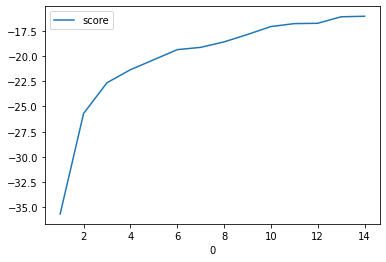

In [27]:
result_df.plot.line(y=1, x=0, label='score')

I run the alghoritm with the best k

In [28]:
# set number of clusters
kclusters = 4


both_cities_clustering = both_cities_clustering_ready.drop('Postal Code', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(both_cities_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

C:\Users\COMARCH\AppData\Local\Temp/ipykernel_16308/3539446756.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  both_cities_clustering = both_cities_clustering_ready.drop('Postal Code', 1)


array([1, 1, 0, 0, 1, 1, 1, 1, 0, 0])

I add cluster labels to the dataframe with human readable information

In [29]:
both_cities_merged = pd.concat([berlin_merged, amsterdam_merged])
both_cities_merged.sort_values(by=['Postal Code'], inplace=True)

both_cities_merged.insert(1, 'Cluster Labels', kmeans.labels_)

both_cities_merged.head()

,Postal Code,Cluster Labels,City,Administrative Region,Population,Area km²,Population density per km²,Median Age,Neighborhoods,Latitude,Longitude
0,1011,1,Amsterdam,North Holland,6606,1.032,6401.16,36.3,"Amsterdam-Centrum, Stadsdeel Centrum",52.371124,4.903752
1,1012,1,Amsterdam,North Holland,7067,1.207,5855.01,36.3,"Amsterdam-Centrum, Centrum, De Wallen, Stadsde...",52.373179,4.894910
2,1013,0,Amsterdam,North Holland,26792,6.300,4252.70,36.3,"Amsterdam-Centrum, Amsterdam-West, Haarlemmerb...",52.387662,4.883396
3,1014,0,Amsterdam,North Holland,15056,2.699,5578.36,36.3,"Amsterdam-West, Bedrijventerrein Sloterdijk, S...",52.393066,4.853503
4,1015,1,Amsterdam,North Holland,5926,0.776,7636.60,36.3,"Amsterdam-Centrum, Grachtengordel-West, Jordaan",52.378205,4.882973


In [30]:
# create map
berlin_cluster_map = folium.Map(location=[berlin_lat, berlin_lon], zoom_start=10)
amsterdam_cluster_map = folium.Map(location=[amsterdam_lat, amsterdam_lon], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, neigh, cluster in zip(both_cities_merged['Latitude'], both_cities_merged['Longitude'], both_cities_merged['Postal Code'], both_cities_merged['Neighborhoods'], both_cities_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' ' + str(neigh) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(berlin_cluster_map)

markers_colors = []
for lat, lon, poi, neigh, cluster in zip(both_cities_merged['Latitude'], both_cities_merged['Longitude'], both_cities_merged['Postal Code'], both_cities_merged['Neighborhoods'], both_cities_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' ' + str(neigh) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(amsterdam_cluster_map)

# Results and Discussion
I make visualisation of the clusters.
Both cities were divided in 4 clusters, they are arranged in a shape that is similar to ring or circle, that is expected of cities, further from the center the type of neighberhood changes the most.
It's clearly visible that cluser 1 represents city centre, cluster 0 outer part of the city, cluster 2 and 3 also are located on the most outer part of the city, I need more data on the venues to distinguish them better.

In [31]:
%%capture --no-display
show_maps_sidebyside(berlin_cluster_map, amsterdam_cluster_map)

Then I prepare a dataframe with human readable information about the most popular venues to be able to get conclusions

In [32]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
    
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Postal Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['Postal Code'] = both_cities_grouped['Postal Code']

for ind in np.arange(both_cities_grouped.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(both_cities_grouped.iloc[ind, :], num_top_venues)

venues_sorted.head()

,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1011,Bar,Hotel,Café,Chinese Restaurant,Grocery Store,Cocktail Bar,Bike Rental / Bike Share,Ice Cream Shop,Bagel Shop,Convenience Store
1,1012,Hotel,Coffee Shop,Bar,Café,Cocktail Bar,Bakery,Museum,Marijuana Dispensary,Salon / Barbershop,French Restaurant
2,1013,Bar,Restaurant,Coffee Shop,Italian Restaurant,Café,Tapas Restaurant,Deli / Bodega,Hotel,Thai Restaurant,Market
3,1014,Soccer Field,Music Venue,Thrift / Vintage Store,Paper / Office Supplies Store,Canal Lock,Fast Food Restaurant,Farm,Dog Run,Nightclub,Climbing Gym
4,1015,Bar,Italian Restaurant,Café,Sandwich Place,Hotel,Coffee Shop,Thai Restaurant,Spanish Restaurant,Seafood Restaurant,Indonesian Restaurant


In [33]:
result_df = pd.merge(both_cities_merged[['Postal Code', 'Cluster Labels', 'City', 'Population density per km²', 'Neighborhoods']].sort_values('Postal Code'),
    venues_sorted, on='Postal Code')

## Cluster 0
Outer part of the city still close to center, this are still have plenty of food venues, but is characterized by more utility venues like supermarket and other stores, gyms. 
## Cluster 1
This cluster is located in the city center, the area is full of cafes, restaurants, bars, generally its the center of entertainment. It's also densely  packed area

Most outer part of the city
## Cluster 2
This cluster is dominated with supermarkets and other stores, bus and tram stops. There are way less restaurants, we can find also venues like warehouse stores. This cluster have similar population density to cluster 0. There are only two places in Amsterdam within this cluster.
## Cluster 3
This cluster is similar to above cluster but there are way less venues, there is presence of lakes. This cluser have the least dense population

## Cluster 0

In [34]:
result_df.loc[result_df['Cluster Labels']  == 0].sample(15)

,Postal Code,Cluster Labels,City,Population density per km²,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
230,13405,0,Berlin,3880.28,"Bezirk Reinickendorf, Flughafen Tegel, Mitte, ...",Bus Stop,Argentinian Restaurant,Metro Station,Bakery,Squash Court,Hotel,ATM,Rental Car Location,Soccer Field,Playground
155,12157,0,Berlin,5233.69,"Bezirk Steglitz-Zehlendorf, Bezirk Tempelhof-S...",Soccer Field,Park,Gym,Ice Cream Shop,Track,Flower Shop,Supermarket,Plaza,Warehouse Store,Turkish Restaurant
174,12349,0,Berlin,4899.85,"Bezirk Neukölln, Buckow",Café,Playground,German Restaurant,Supermarket,Restaurant,Outdoor Sculpture,Field,Garden,ATM,Italian Restaurant
269,14195,0,Berlin,4181.79,"Bezirk Charlottenburg-Wilmersdorf, Bezirk Steg...",Park,German Restaurant,Café,Restaurant,Museum,Bus Stop,Italian Restaurant,Art Museum,Science Museum,Bakery
181,12437,0,Berlin,3911.36,"Baumschulenweg, Bezirk Treptow-Köpenick",Supermarket,Playground,Drugstore,Bus Stop,Park,Café,Bakery,Light Rail Station,Soccer Field,Boat or Ferry
9,1021,0,Amsterdam,4400.40,"Amsterdam-Noord, Nieuwendammerham",Brewery,Café,Art Gallery,Hookah Bar,Burger Joint,Asian Restaurant,Market,Seafood Restaurant,Supermarket,Bus Stop
252,13599,0,Berlin,3762.53,"Bezirk Spandau, Haselhorst",Supermarket,German Restaurant,Café,Park,Soccer Field,Print Shop,Music Venue,Metro Station,Restaurant,Paintball Field
23,1041,0,Amsterdam,4964.07,"Leidsche Rijn, Westpoort",Harbor / Marina,Electronics Store,Liquor Store,Accessories Store,Tram Station,Windmill,Whisky Bar,Warehouse Store,Vietnamese Restaurant,Video Store
172,12309,0,Berlin,3803.55,"Bezirk Tempelhof-Schöneberg, Lichtenrade",German Restaurant,Bus Stop,Park,Restaurant,Accessories Store,Tunnel,Windmill,Whisky Bar,Warehouse Store,Vietnamese Restaurant
19,1033,0,Amsterdam,4934.55,"Amsterdam-Noord, Stadsdeel Noord",Bus Stop,Pharmacy,Harbor / Marina,Business Service,Chinese Restaurant,Convenience Store,Furniture / Home Store,Gym,Gym Pool,Theater


## Cluster 1

In [35]:
result_df.loc[result_df['Cluster Labels']  == 1].sample(15)

,Postal Code,Cluster Labels,City,Population density per km²,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
140,12043,1,Berlin,7370.90,"Bezirk Neukölln, Karl-Marx-Straße, Neukölln",Café,Coffee Shop,Bar,Middle Eastern Restaurant,Bistro,Food & Drink Shop,German Restaurant,Vegetarian / Vegan Restaurant,Italian Restaurant,Thrift / Vintage Store
37,1058,1,Amsterdam,6276.60,"Amsterdam Nieuw-West, Amsterdam-West, Hoofddor...",Café,Restaurant,Diner,Supermarket,Snack Place,French Restaurant,Gym / Fitness Center,Hotel,Bar,Coffee Shop
134,10963,1,Berlin,7039.70,"Bezirk Friedrichshain-Kreuzberg, Kreuzberg, Vi...",Café,Hotel,Park,Theater,Asian Restaurant,Organic Grocery,Ice Cream Shop,Historic Site,Hostel,Science Museum
129,10823,1,Berlin,7278.25,"Akazienkiez, Bezirk Tempelhof-Schöneberg, Schö...",Ice Cream Shop,Café,Grocery Store,Bistro,Pizza Place,French Restaurant,Spa,Bakery,Wine Bar,Tea Room
94,10365,1,Berlin,6561.82,"Bezirk Lichtenberg, Rüdigerstraße",Vietnamese Restaurant,Tram Station,Market,Supermarket,Park,Music Venue,Hotel,Soccer Field,Gym / Fitness Center,Bowling Alley
103,10551,1,Berlin,7620.02,"Mitte, Turmstraße",Cocktail Bar,Supermarket,Breakfast Spot,Bar,Café,Restaurant,Hotel,Hostel,Vegetarian / Vegan Restaurant,German Restaurant
99,10409,1,Berlin,7151.11,"Bezirk Pankow, Greifswalder Straße-Nord, Prenz...",Supermarket,Drugstore,Organic Grocery,Café,Paper / Office Supplies Store,Chinese Restaurant,Ice Cream Shop,Sporting Goods Shop,Hardware Store,Gym / Fitness Center
63,1091,1,Amsterdam,7185.22,"Amsterdam-Oost, Oosterparkbuurt, Weesperzijde",Italian Restaurant,Coffee Shop,Breakfast Spot,Supermarket,Hotel Bar,Café,Restaurant,Bar,Bakery,Hotel
117,10711,1,Berlin,6578.04,"Bezirk Charlottenburg-Wilmersdorf, Joachim-Fri...",Plaza,Italian Restaurant,Drugstore,Gym / Fitness Center,Supermarket,Hotel,Café,Ice Cream Shop,Spanish Restaurant,Steakhouse
163,12205,1,Berlin,5846.72,"Bezirk Steglitz-Zehlendorf, Drakestraße",Hotel,Hostel,German Restaurant,Organic Grocery,Lawyer,Greek Restaurant,Bus Stop,Italian Restaurant,Café,Vietnamese Restaurant


## Cluster 2

In [36]:
result_df.loc[result_df['Cluster Labels']  == 2].sample(15)

,Postal Code,Cluster Labels,City,Population density per km²,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
198,12627,2,Berlin,3862.94,"Bezirk Marzahn-Hellersdorf, Hellersdorf",Supermarket,Shopping Mall,Gym / Fitness Center,Electronics Store,Metro Station,Tunnel,Windmill,Whisky Bar,Warehouse Store,Vietnamese Restaurant
186,12524,2,Berlin,4854.49,"Altglienicke, Bezirk Treptow-Köpenick",Supermarket,Bowling Alley,Greek Restaurant,Bakery,Miscellaneous Shop,Home Service,Accessories Store,Whisky Bar,Warehouse Store,Vietnamese Restaurant
149,12099,2,Berlin,6123.63,"Alt-Tempelhof, Bezirk Tempelhof-Schöneberg, Te...",Supermarket,Candy Store,Art Gallery,Bus Stop,Skate Park,Film Studio,Automotive Shop,Rental Car Location,Auto Dealership,Italian Restaurant
185,12489,2,Berlin,5672.00,"Adlershof, Bezirk Treptow-Köpenick",Supermarket,Greek Restaurant,Italian Restaurant,Gas Station,Drugstore,Automotive Shop,Furniture / Home Store,Steakhouse,Park,Salad Place
187,12526,2,Berlin,4139.13,Bezirk Treptow-Köpenick,Supermarket,Light Rail Station,Home Service,Food Truck,Discount Store,Accessories Store,Tunnel,Whisky Bar,Warehouse Store,Vietnamese Restaurant
191,12557,2,Berlin,3354.19,"Bezirk Treptow-Köpenick, Köpenick",Supermarket,Tram Station,German Restaurant,Harbor / Marina,Bus Stop,Park,Drugstore,Soccer Field,Café,Restaurant
93,10319,2,Berlin,4907.41,"Alt-Friedrichsfelde, Bezirk Lichtenberg",Supermarket,Zoo Exhibit,Drugstore,Zoo,Hotel,Gym / Fitness Center,Snack Place,Shopping Mall,Gift Shop,Coffee Shop
164,12207,2,Berlin,4627.64,"Bezirk Steglitz-Zehlendorf, Ostpreußendamm",Supermarket,Bus Stop,Italian Restaurant,Café,Restaurant,Chinese Restaurant,Ice Cream Shop,Hostel,Big Box Store,Snack Place
90,10315,2,Berlin,6166.60,"Alt-Friedrichsfelde, Bezirk Lichtenberg",Supermarket,Tram Station,Bakery,Memorial Site,Zoo Exhibit,Metro Station,Asian Restaurant,Gastropub,Bus Stop,Drugstore
169,12279,2,Berlin,6128.62,"Bezirk Tempelhof-Schöneberg, Marienfelde",Bus Stop,Supermarket,Pizza Place,Chinese Restaurant,Tram Station,Windmill,Whisky Bar,Warehouse Store,Vietnamese Restaurant,Video Store


## Cluster 3

In [37]:
result_df.loc[result_df['Cluster Labels']  == 3].sample(15)

,Postal Code,Cluster Labels,City,Population density per km²,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,1026,3,Amsterdam,237.58,"Amsterdam-Noord, Waterland",Restaurant,Café,Burger Joint,Grocery Store,Diner,Garden,Tunnel,Harbor / Marina,Bus Stop,Pier
80,1114,3,Amsterdam,1659.54,"Amsterdam-Oost, De Omval, Duivendrecht, Zuidoost",Restaurant,Big Box Store,Convenience Store,Hotel,Paper / Office Supplies Store,Snack Place,Deli / Bodega,Grocery Store,Bookstore,Cosmetics Shop
214,13125,3,Berlin,1705.36,"Bezirk Pankow, Buch, Karow",Supermarket,Light Rail Station,Lake,Bus Stop,Drugstore,Restaurant,Italian Restaurant,Business Service,Health & Beauty Service,Big Box Store
268,14193,3,Berlin,868.05,"Bezirk Charlottenburg-Wilmersdorf, Grunewald",German Restaurant,Lake,Nature Preserve,Café,Italian Restaurant,Historic Site,Dog Run,Supermarket,Light Rail Station,Moving Target
257,14053,3,Berlin,2588.81,"Bezirk Charlottenburg-Wilmersdorf, Pichelsberg",Soccer Stadium,Lounge,Sports Club,Sporting Goods Shop,Athletics & Sports,Amphitheater,Stadium,Pool,Scenic Lookout,Restaurant
273,15366,3,Neuenhagen bei Berlin,671.72,"Dahlwitz-Hoppegarten, Hönow, Neuenhagen",Supermarket,Hotel,German Restaurant,Light Rail Station,Racecourse,Miscellaneous Shop,Shopping Mall,Greek Restaurant,Metro Station,Discount Store
11,1023,3,Amsterdam,2359.65,Amsterdam-Noord,Supermarket,Snack Place,Indonesian Restaurant,Tennis Court,Concert Hall,Convenience Store,Bakery,Bar,Park,Discount Store
264,14163,3,Berlin,2679.25,"Bezirk Steglitz-Zehlendorf, Zehlendorf",Italian Restaurant,Café,Soccer Field,German Restaurant,Gas Station,Bakery,Gourmet Shop,Doner Restaurant,Gym / Fitness Center,Snack Place
62,1087,3,Amsterdam,912.35,"Amsterdam-Oost, IJburg West",Park,Beach,Bistro,Pizza Place,Gym,Department Store,Italian Restaurant,Bakery,Tram Station,Farmers Market
193,12587,3,Berlin,1259.82,"Bezirk Treptow-Köpenick, Friedrichshagen",Café,Ice Cream Shop,Asian Restaurant,Supermarket,Liquor Store,Bar,Organic Grocery,Beach,Snack Place,Movie Theater


# Conclusion 

This project intention was to find if the two city share some similarities and if so, which part of the cities share these similarities. By clustering both cities as they were one entity I was able to find similar areas in both cities. Tourist could use the information to know which zones could be of their interest, people who would like to move from one city to the other could use this information the choose better where to get an apartment based on their preferences.

Author: Krzysztof Zwolenik